In [58]:
# Import necessary libraries

import numpy as np  # For numerical operations and handling arrays
import os  # For interacting with the operating system (e.g., file and directory management)
import cv2  # OpenCV library for image processing and computer vision tasks
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier from scikit-learn
from sklearn.metrics import accuracy_score  # For evaluating the accuracy of the classification model
import matplotlib.pyplot as plt  # For visualizing data and results using plots


In [59]:
import kagglehub # Library used to download datasets from Kaggle easily

# Download latest version
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")

# Print the local file path where the dataset has been downloaded
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/att-database-of-faces


In [60]:
import os  # Used for interacting with the file system

# Display the dataset path
print("Dataset path:", path)

# List and print the contents (folders/files) inside the dataset directory
print("Contents:")
print(os.listdir(path))


Dataset path: /kaggle/input/att-database-of-faces
Contents:
['s32', 's39', 's26', 's20', 's18', 's25', 's24', 's14', 's40', 's27', 's33', 'README', 's1', 's11', 's31', 's35', 's13', 's19', 's29', 's37', 's10', 's8', 's5', 's7', 's28', 's9', 's15', 's21', 's2', 's6', 's30', 's3', 's23', 's4', 's16', 's38', 's17', 's36', 's22', 's34', 's12']


In [61]:
import os
import numpy as np
from PIL import Image
import kagglehub

# Download the "ATT Database of Faces" dataset from Kaggle and get the local path
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")
print("Path to dataset files:", path)

# Setup parameters
data_path = path  # Dataset folders (s1 to s40) are located directly under this path
num_subjects = 40  # Number of distinct subjects in the dataset
images_per_subject = 10  # Number of images per subject
image_size = (112, 92)  # Size of each image (height x width)
flatten_size = image_size[0] * image_size[1]  # Total number of pixels per flattened image

# Initialize data matrix D and label vector y
# D: each row corresponds to one flattened image
# y: each element corresponds to the label (subject ID) of the image
D = np.zeros((num_subjects * images_per_subject, flatten_size), dtype=np.uint8)
y = np.zeros((num_subjects * images_per_subject,), dtype=np.int32)

# Load images from each subject folder, convert to grayscale, flatten, and store in D
# Assign corresponding subject labels in y
index = 0
for subject_id in range(1, num_subjects + 1):
    subject_path = os.path.join(data_path, f"s{subject_id}")
    for img_index in range(1, images_per_subject + 1):
        img_path = os.path.join(subject_path, f"{img_index}.pgm")
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        D[index, :] = np.array(img).flatten()  # Flatten the image into 1D array
        y[index] = subject_id  # Assign the label as the subject ID
        index += 1

# Print the shape of the data matrix and label vector to verify loading
print("Data matrix shape:", D.shape)
print("Labels shape:", y.shape)


Path to dataset files: /kaggle/input/att-database-of-faces
Data matrix shape: (400, 10304)
Labels shape: (400,)


In [62]:
# Split the dataset into training and testing sets using simple slicing:
# X_train contains images at even indices (0, 2, 4, ...), considered the "odd" samples
# X_test contains images at odd indices (1, 3, 5, ...), considered the "even" samples
X_train = D[::2]  # Select every second image starting from index 0 (even)
X_test = D[1::2]  # Select every second image starting from index 1 (odd)
y_train = y[::2]  # Corresponding labels for training images
y_test = y[1::2]  # Corresponding labels for testing images

# Print shapes to verify the split
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Training set shape: (200, 10304)
Test set shape: (200, 10304)


In [63]:
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.neighbors import KNeighborsClassifier  # KNN classifier
from sklearn.metrics import accuracy_score  # Accuracy evaluation metric

# List of explained variance ratios (alpha values) to keep in PCA
alphas = [0.8, 0.85, 0.9, 0.95]
accuracies = []  # To store accuracy results for each alpha

for alpha in alphas:
    # Create a PCA object to retain the given fraction of variance (alpha)
    pca = PCA(n_components=alpha, svd_solver='full')

    # Fit PCA on training data and apply dimensionality reduction
    X_train_pca = pca.fit_transform(X_train)

    # Transform test data using the same PCA model
    X_test_pca = pca.transform(X_test)

    # Initialize KNN classifier with 1 nearest neighbor
    knn = KNeighborsClassifier(n_neighbors=1)

    # Train KNN classifier on the PCA-transformed training data
    knn.fit(X_train_pca, y_train)

    # Predict the labels for test data
    y_pred = knn.predict(X_test_pca)

    # Calculate classification accuracy on the test set
    acc = accuracy_score(y_test, y_pred)

    # Store the accuracy for this alpha
    accuracies.append(acc)

    # Print the alpha and corresponding accuracy
    print(f"Alpha: {alpha}, Accuracy: {acc:.4f}")


Alpha: 0.8, Accuracy: 0.9500
Alpha: 0.85, Accuracy: 0.9500
Alpha: 0.9, Accuracy: 0.9400
Alpha: 0.95, Accuracy: 0.9400


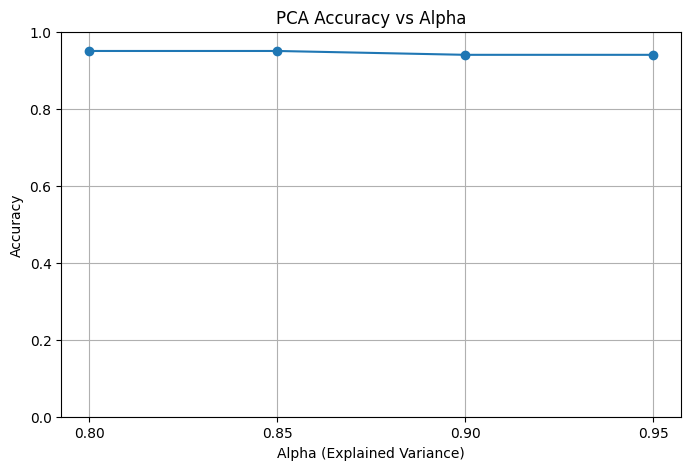

In [64]:
import matplotlib.pyplot as plt  # Library for creating visualizations

# Create a new figure with size 8x5 inches
plt.figure(figsize=(8, 5))

# Plot accuracy values against the PCA explained variance ratios (alphas)
# 'marker' sets circle markers on data points
# 'linestyle' connects points with a solid line
plt.plot(alphas, accuracies, marker='o', linestyle='-')

# Add title and axis labels
plt.title('PCA Accuracy vs Alpha')
plt.xlabel('Alpha (Explained Variance)')
plt.ylabel('Accuracy')

# Enable grid for easier reading
plt.grid(True)

# Set x-axis ticks explicitly to the alpha values
plt.xticks(alphas)

# Set y-axis limits from 0 to 1 (accuracy range)
plt.ylim(0, 1)

# Display the plot
plt.show()


In [65]:
from numpy.linalg import eig  # For eigenvalue and eigenvector computation
from sklearn.preprocessing import StandardScaler  # For feature standardization

# Ensure the data is of type float64 (needed for LDA calculations)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

# Standardize the data (zero mean and unit variance)
# This step is optional but generally improves LDA performance
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Compute the overall mean vector across all training samples
mean_overall = np.mean(X_train_std, axis=0)

# Initialize within-class scatter matrix (Sw) and between-class scatter matrix (Sb)
Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
Sb = np.zeros_like(Sw)

# Calculate Sw and Sb
for class_label in np.unique(y_train):
    X_class = X_train_std[y_train == class_label]  # Samples of the current class
    mean_class = np.mean(X_class, axis=0)  # Mean vector of current class

    # Within-class scatter: sum of covariance matrices of each class
    Sw += (X_class - mean_class).T @ (X_class - mean_class)

    # Between-class scatter: weighted difference of class mean from overall mean
    n_class = X_class.shape[0]  # Number of samples in current class
    mean_diff = (mean_class - mean_overall).reshape(-1, 1)
    Sb += n_class * (mean_diff @ mean_diff.T)

# Solve the generalized eigenvalue problem for inv(Sw)*Sb
eigvals, eigvecs = eig(np.linalg.pinv(Sw) @ Sb)

# Sort eigenvectors by descending eigenvalues (importance)
sorted_indices = np.argsort(-eigvals.real)
eigvecs = eigvecs[:, sorted_indices]

# Select the first 39 eigenvectors (LDA components)
U_lda = eigvecs[:, :39].real

# Project training and testing data onto the LDA subspace
X_train_lda = X_train_std @ U_lda
X_test_lda = X_test_std @ U_lda

# Classification using 1-Nearest Neighbor on LDA features
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_lda, y_train)
y_pred = knn.predict(X_test_lda)

# Calculate and print accuracy
acc_lda = accuracy_score(y_test, y_pred)
print(f"LDA Accuracy (39 components): {acc_lda:.4f}")


LDA Accuracy (39 components): 0.5050


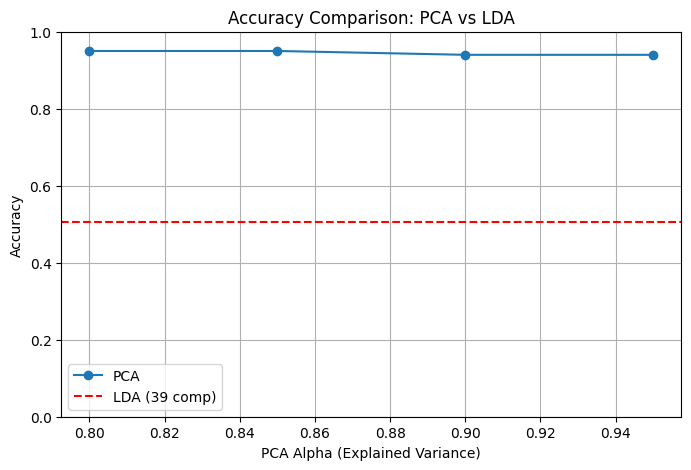

In [66]:
import matplotlib.pyplot as plt  # Library for plotting

# Create a figure of size 8x5 inches
plt.figure(figsize=(8, 5))

# Plot PCA accuracies against the alpha values with markers and label
plt.plot(alphas, accuracies, marker='o', label='PCA')

# Add a horizontal dashed line to show LDA accuracy for comparison
plt.axhline(y=acc_lda, color='r', linestyle='--', label='LDA (39 comp)')

# Add title and axis labels
plt.title('Accuracy Comparison: PCA vs LDA')
plt.xlabel('PCA Alpha (Explained Variance)')
plt.ylabel('Accuracy')

# Enable grid for readability
plt.grid(True)

# Show legend to distinguish PCA and LDA lines
plt.legend()

# Set y-axis limits between 0 and 1 (accuracy range)
plt.ylim(0, 1)

# Display the plot
plt.show()


In [67]:
# Define a list of different k values (number of neighbors) to test in KNN
k_values = [1, 3, 5, 7]

# Lists to store accuracies for PCA and LDA approaches
pca_accuracies = []
lda_accuracies = []

# -------- PCA with alpha = 0.95 --------
pca = PCA(n_components=0.95, svd_solver='full')  # Retain 95% variance in PCA
X_train_pca = pca.fit_transform(X_train)  # Fit and transform training data
X_test_pca = pca.transform(X_test)  # Transform test data

# Evaluate KNN classifier on PCA features with different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    pca_accuracies.append(acc)  # Store PCA accuracy for this k

# -------- LDA (fixed projection from earlier) --------
# Evaluate KNN classifier on LDA features with different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_lda, y_train)
    y_pred = knn.predict(X_test_lda)
    acc = accuracy_score(y_test, y_pred)
    lda_accuracies.append(acc)  # Store LDA accuracy for this k


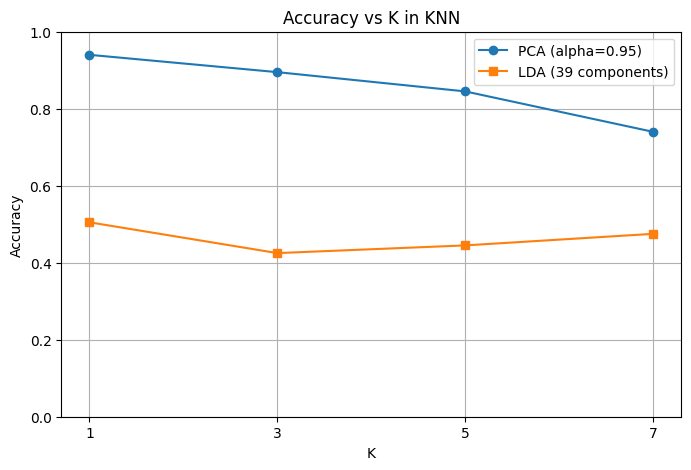

In [68]:
import matplotlib.pyplot as plt  # Library for plotting

# Create a figure of size 8x5 inches
plt.figure(figsize=(8, 5))

# Plot accuracy for PCA-based KNN against different k values with circle markers
plt.plot(k_values, pca_accuracies, marker='o', label='PCA (alpha=0.95)')

# Plot accuracy for LDA-based KNN against different k values with square markers
plt.plot(k_values, lda_accuracies, marker='s', label='LDA (39 components)')

# Add title and axis labels
plt.title('Accuracy vs K in KNN')
plt.xlabel('K')
plt.ylabel('Accuracy')

# Set x-axis ticks to the k values tested
plt.xticks(k_values)

# Enable grid for easier readability
plt.grid(True)

# Display legend to distinguish PCA and LDA curves
plt.legend()

# Set y-axis limits between 0 and 1 (accuracy range)
plt.ylim(0, 1)

# Show the plot
plt.show()



Bouns

In [69]:
# Open the file "non_face.zip" in binary read mode
with open("non_face.zip", "rb") as f:
    # Read the first 100 bytes from the file
    header = f.read(100)

    # Print the raw bytes read from the file header
    print(header)

b'PK\x03\x04\n\x00\x00\x00\x00\x00\xc9\x8a\xb7Z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\t\x00\x00\x00non_face/PK\x03\x04\x14\x00\x00\x00\x08\x00\xc7\x89\xb7Z\xbf\xd5\xd7\xc5\xb8\xc6\x19\x00e.\x1a\x00.\x00\x00\x00non_face/aaron-burden-OA6OuqfSW'


In [70]:
import zipfile  # Module for working with ZIP archives
import os       # Module for interacting with the file system

zip_path = "non_face.zip"  # ZIP file name to be extracted
extract_dir = "non_face"   # Directory where files will be extracted

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all contents of the ZIP archive into the specified directory
    zip_ref.extractall(extract_dir)

# Print confirmation message after extraction completes
print(f"✅Done")



✅Done


In [71]:
from PIL import Image  # For image loading and processing
import numpy as np
import os

non_face_dir = "/content/non_face/non_face"  # Directory containing non-face images
image_size = (112, 92)  # Target size to match face images (height x width)
non_faces = []  # List to store flattened non-face images

# Loop over all files in the non-face directory
for filename in os.listdir(non_face_dir):
    # Consider only common image file extensions (case-insensitive)
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        path = os.path.join(non_face_dir, filename)
        # Open image, convert to grayscale ("L"), and resize to target dimensions
        img = Image.open(path).convert("L").resize(image_size)
        # Flatten the image into a 1D array and append to list
        non_faces.append(np.array(img).flatten())

# Print the number of non-face images loaded
print(f"number of non_face {len(non_faces)}")

# Convert list to NumPy array for further processing
X_nonfaces = np.array(non_faces)

# Create label array with zeros (label=0 for non-face class)
y_nonfaces = np.zeros(len(X_nonfaces), dtype=int)


number of non_face 48


In [72]:
# Select the first 40 face images from the dataset matrix D
X_faces = D[:40]  # Extract first 40 face samples

# Create a label array of ones corresponding to the face class
# Label '1' indicates face images
y_faces = np.ones(40, dtype=int)



In [73]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Combine face and non-face data vertically into one dataset
X_binary = np.vstack((X_faces, X_nonfaces))

# Combine their corresponding labels into one array
y_binary = np.concatenate((y_faces, y_nonfaces))

# Standardize the combined dataset (zero mean, unit variance)
X_binary_std = StandardScaler().fit_transform(X_binary)

# Apply Linear Discriminant Analysis for binary classification with 1 component
lda = LinearDiscriminantAnalysis(n_components=1)
X_binary_lda = lda.fit_transform(X_binary_std, y_binary)

# Split data into training and testing sets (70% train, 30% test)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary_lda, y_binary, test_size=0.3, random_state=42)

# Train 1-Nearest Neighbor classifier on the training set
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_bin, y_train_bin)

# Predict labels for the test set
y_pred_bin = knn.predict(X_test_bin)

# Calculate and print classification accuracy
acc_bin = accuracy_score(y_test_bin, y_pred_bin)
print(f"Face vs Non-Face Accuracy: {acc_bin:.4f}")


Face vs Non-Face Accuracy: 1.0000


**Summary:**

* Combines face (label=1) and non-face (label=0) datasets.

* Standardizes features.

* Uses LDA to reduce to 1 discriminant component (binary problem).

* Splits into train/test sets.

* Classifies using 1-NN and reports accuracy.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


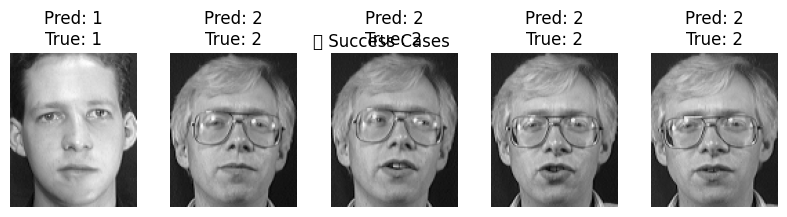

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


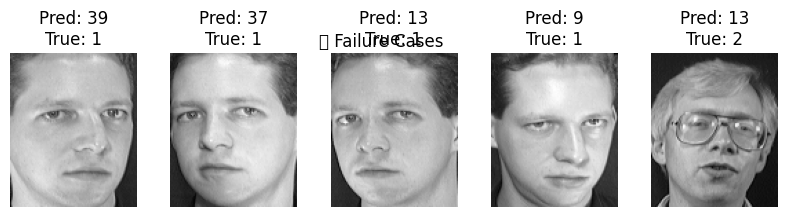

In [74]:
import matplotlib.pyplot as plt  # For plotting images

# Find indices where predictions matched the true labels (successes)
success_idx = np.where(y_pred == y_test)[0]

# Find indices where predictions did not match true labels (failures)
fail_idx = np.where(y_pred != y_test)[0]

# Function to display first 5 images from given indices with predictions and true labels
def show_images(indices, title, label):
    plt.figure(figsize=(10, 2))  # Create a wide figure to fit 5 images in a row
    for i, idx in enumerate(indices[:5]):  # Show up to 5 images
        img = X_test[idx].reshape(112, 92)  # Reshape flattened image back to 2D
        plt.subplot(1, 5, i + 1)  # Create subplot for each image
        plt.imshow(img, cmap='gray')  # Show grayscale image
        plt.title(f'Pred: {y_pred[idx]}\nTrue: {y_test[idx]}')  # Show predicted and true label
        plt.axis('off')  # Hide axis ticks and labels
    plt.suptitle(title)  # Title for the whole figure
    plt.show()

# Display some successful predictions
show_images(success_idx, "✅ Success Cases", 1)

# Display some failed predictions
show_images(fail_idx, "❌ Failure Cases", 0)


In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# List of different counts of non-face images to test
non_face_counts = [20, 40, 60, 80]

# To store the accuracy results for each count
accuracies = []

for count in non_face_counts:
    # Check if we have enough non-face samples available
    if len(X_nonfaces) < count:
        print(f"❌ Skipping count = {count}, not enough non-face images.")
        continue

    # Select the first 'count' non-face images and their labels (0)
    X_nf = X_nonfaces[:count]
    y_nf = np.zeros(count, dtype=int)

    # Combine the face images and non-face images into one dataset
    X_comb = np.vstack((X_faces, X_nf))
    y_comb = np.concatenate((y_faces, y_nf))

    # Verify that features and labels have matching shapes
    if X_comb.shape[0] != y_comb.shape[0]:
        print(f"❌ Skipping count = {count}, shape mismatch.")
        continue

    # Standardize combined data (zero mean, unit variance)
    X_std = StandardScaler().fit_transform(X_comb)

    # Apply LDA with 1 component to the standardized data
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X_std, y_comb)

    # Split data into training and test sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_lda, y_comb, test_size=0.3, random_state=42)

    # Train 1-NN classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)

    # Predict test labels and compute accuracy
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"✅ Count = {count}, Accuracy = {acc:.4f}")


✅ Count = 20, Accuracy = 0.9444
✅ Count = 40, Accuracy = 0.9167
❌ Skipping count = 60, not enough non-face images.
❌ Skipping count = 80, not enough non-face images.


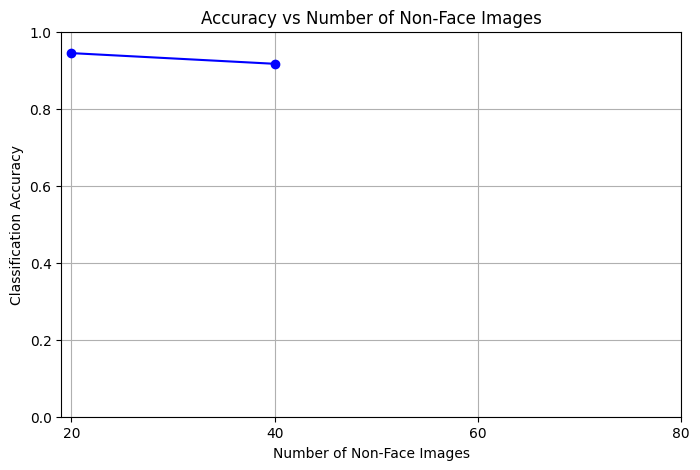

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Set figure size

# Plot accuracy values against the number of non-face images used
plt.plot(non_face_counts[:len(accuracies)], accuracies,
         marker='o', linestyle='-', color='blue')

plt.title("Accuracy vs Number of Non-Face Images")  # Chart title
plt.xlabel("Number of Non-Face Images")             # X-axis label
plt.ylabel("Classification Accuracy")               # Y-axis label

plt.grid(True)          # Enable grid for better readability
plt.ylim(0, 1)          # Y-axis limits from 0 to 1 (accuracy range)
plt.xticks(non_face_counts)  # Set X-axis ticks to match non-face counts

plt.show()  # Display the plot


In [78]:
import numpy as np

# Initialize empty lists for train and test splits
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each subject (40 subjects total)
for subject_id in range(40):
    start = subject_id * 10          # Calculate start index for this subject's images
    imgs = D[start:start+10]         # Extract all 10 images for the current subject
    labels = y[start:start+10]       # Extract corresponding labels

    # Use first 7 images per subject for training
    X_train.extend(imgs[:7])
    y_train.extend(labels[:7])

    # Use last 3 images per subject for testing
    X_test.extend(imgs[7:])
    y_test.extend(labels[7:])

# Convert lists to numpy arrays for machine learning processing
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print shapes of the resulting train and test sets
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (280, 10304) Test: (120, 10304)


In [79]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Apply PCA to training data keeping 95% explained variance
pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)  # Fit PCA on training data and transform it
X_test_pca = pca.transform(X_test)        # Apply the same PCA transform to test data

# Train a 1-Nearest Neighbor classifier on the PCA-transformed training data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)

# Predict the labels for test data
y_pred = knn.predict(X_test_pca)

# Calculate classification accuracy
acc_pca = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy with PCA (7/3 split): {acc_pca:.4f}")


🎯 Accuracy with PCA (7/3 split): 0.9500


**50/50 Split :**

The PCA results with different alphas are calculated, and a plot is shown. The highest accuracy is achieved at **alpha = 0.95.**
The LDA accuracy with 39 components is calculated.
A comparison plot shows the PCA accuracy at various alphas versus the LDA accuracy.
A plot comparing KNN accuracy for PCA (alpha=0.95) and LDA (39 components) at different K values (1, 3, 5, 7) is shown. The accuracy at K=1 for both methods was printed and plotted.



**7/3 Split:**

The code explicitly trains a 1-NN classifier on the PCA-transformed data (**alpha=0.95**) and prints the accuracy.
To compare, we can look at the accuracies obtained using the same dimensionality reduction method (**PCA with 0.95 explained variance**) and the same classifier (1-NN) for both splitting methods.

Let's extract these specific accuracy values from the previous runs:

PCA (alpha=0.95) with 50/50 split and K=1: This value was printed in the loop iterating through alphas and plotted in the "Accuracy vs K in KNN" graph.
PCA (alpha=0.95) with 7/3 split and K=1: This value was printed at the end of the last code block.
You can see the exact values by reviewing the output cells associated with the code where these accuracies were calculated and printed. Generally, with more training data per subject (like in the 7/3 split where 7 out of 10 images are used for training compared to 5 out of 10 in the 50/50 split), you might expect slightly higher accuracy, but this is not always guaranteed and depends on the data